# Correlating Noise

In this workbook we continue building the different validation methods. Specifically we look at how to generate spatially correlated Gaussian noise. We use a very simple method, where we generate random Gaussian noise that isn't correlated. This noise is generated with a standard deviation that is determined from a sigma clipped input image, that is all sources have been removed. The variance of this image is then scaled by the area of the images point spread function. 

Here we apply a simple approximation where we assume the psf to be Gaussian. In reality the extended sidelobe structures of interferometric psf's generate longer scale correlations. There are more indpeth methods for estimating the correlated noise from an image based approach. However, a simple Gaussian assumption accounts for most of the variance, and is a reasonable assumption for testing and validation purposes.

In future we will explore using a more comprehensive method, specifically the method employed by Tsukui et al (2023) (https://arxiv.org/pdf/2301.03579.pdf).

In [1]:
import sys,os
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath('../'))

import warnings
warnings.filterwarnings("ignore")

# Scipy stuff:
import scipy.optimize as opt

# Astropy stuff:
from astropy import wcs
from astropy.wcs import WCS
from astropy.io import fits

# Image processing packages:
from skimage.feature import blob_dog
from skimage.feature import blob_log

# Array module.
import numpy as np

# Module for fitting SNRs
from snrfit import NGaussian2D,SNR_Gauss_fit,determine_peaks_bkg
import snrfit


### Loading in the example file.

In [2]:
path = '../data/'

filename = 'RA225.71_DEC-41.93_170-231MHz.fits'

warnings.filterwarnings("ignore")
with fits.open(path+filename) as hdul:
    #hdul.info()
    header = hdul[0].header
    img_arr = hdul[0].data#[0,0,:,:]

image = np.ones(img_arr.shape)*img_arr

a_psf = header['BMAJ']
b_psf = header['BMIN']
theta_psf = np.radians(header['BPA'])

w = WCS(header).celestial

### Plotting the example image

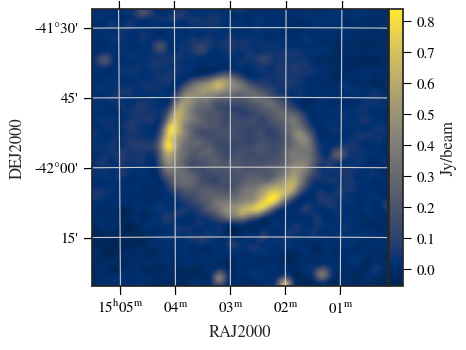

In [3]:
snrfit.astro_plot_2D(img_arr, w, figsize=(7.5,6),scale=0.6)

### Defining the coordinate grid.

In [4]:
X = np.shape(img_arr)[0]
Y = np.shape(img_arr)[1]
print('Image shape (%s,%s)' % (X,Y))

# Defining the pixel grids.
x_pix = np.arange(X)
y_pix = np.arange(Y)
xx_pix, yy_pix = np.meshgrid(x_pix,y_pix)

# This is the pixel scale in degrees.
dx = np.abs(header['CD1_1']) #pixel scale in degrees [deg]

print('dx = %5.3e [deg]' % dx)

Image shape (129,129)
dx = 7.697e-03 [deg]


### Generating the image mask and calculating the background intensity.

In [5]:


RA_SN1006 = header['CRVAL1']
DEC_SN1006 = header['CRVAL2']
Major = 0.55*60 #deg

# Getting the corresponding pixel coordinates for the image centre.
x_cent,y_cent = w.wcs_world2pix(RA_SN1006,DEC_SN1006,1)
print('Image pixel center = (%5.3f, %5.3f)' % (x_cent,y_cent))

# The RA and DEC arrays, can use to determine angular mask.
RA_arr, DEC_arr = w.wcs_pix2world(xx_pix + 1, yy_pix + 1, 1)
print('Determined the RA and DEC for the entire pixel grid.')

# Calculating the angular distance from the image centre to each pixel.
theta_dist = np.degrees(snrfit.great_circle_dist(np.radians(DEC_SN1006),
                    np.radians(DEC_arr),np.radians(RA_SN1006),np.radians(RA_arr)))
print('Calculated the angular distance from each pixel to the image centre.')

# Temporary index array. Used for masking the image. Size padded.
theta_ind_arr_ge = theta_dist >= 0.5*Major/60 + 7.5*dx

img_bkg,rms,thresh_mask = snrfit.calc_img_bkg_rms(img_arr,mask_arr=theta_ind_arr_ge,
                                      sigma_thresh=2.5,Niter=5,mask_cond=True,plot_cond=False)

Image pixel center = (64.667, 64.667)
Determined the RA and DEC for the entire pixel grid.
Calculated the angular distance from each pixel to the image centre.
Max pixel = 0.1019
Max pixel = 0.0709
Max pixel = 0.0684
Max pixel = 0.0681
Max pixel = 0.0680


### Masking the image.

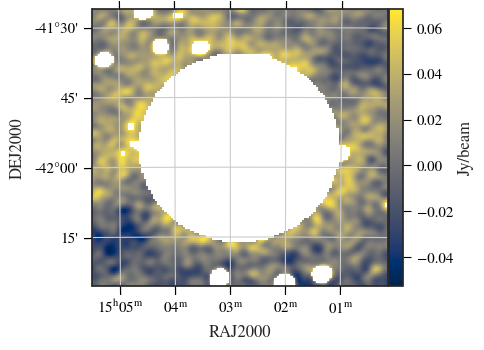

In [6]:
img_nu = np.ones(img_arr.shape)*img_arr# - img_bkg
img_nu[thresh_mask] = np.nan

snrfit.astro_plot_2D(img_nu, w, figsize=(7.5,6),scale=0.6)

### Generating the correlated noise.

Plotting psf image...


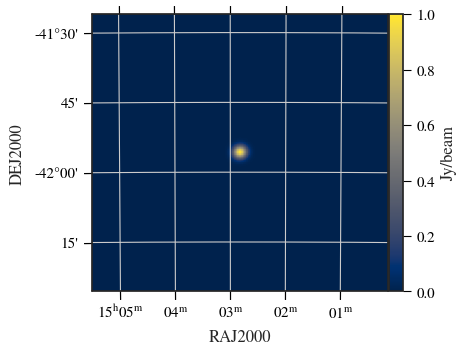

Plotting uncorrelated noise image...


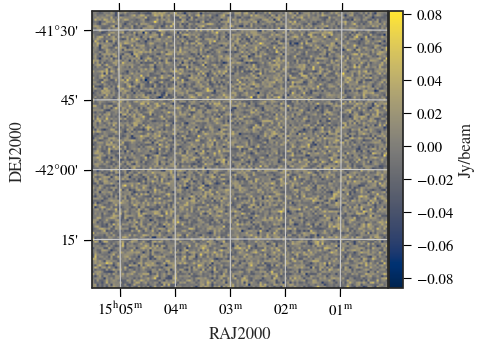

Rescaling factor = 7.152
Input standard deviation is 0.021
Correlated standard deviation is 0.021


In [7]:
img_cor_noise = snrfit.generate_correlated_noise(rms,(a_psf/dx,b_psf/dx,theta_psf),
                                              img_arr.shape,w=w,verbose=True)

### Plotting the correlated noise.

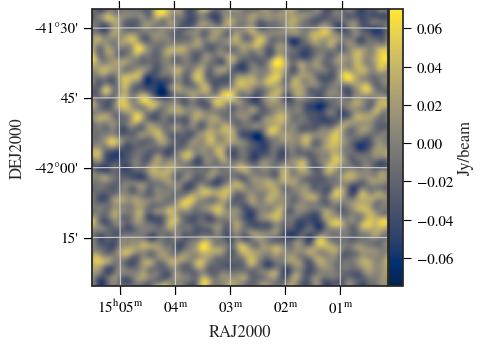

In [8]:
snrfit.astro_plot_2D(img_cor_noise, w, figsize=(7.5,6),scale=0.6)

### Example of the correlated noise with the same mask applied.

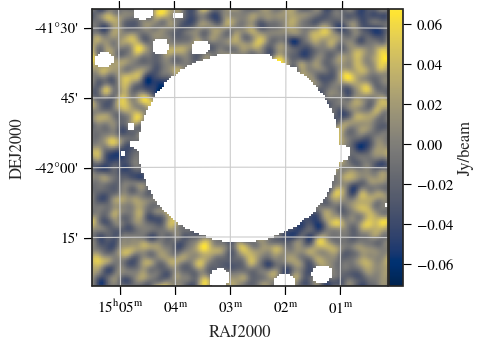

In [9]:
img_cor_masked = img_cor_noise*np.ones(img_cor_noise.shape)
img_cor_masked[thresh_mask] = np.nan

snrfit.astro_plot_2D(img_cor_masked, w, figsize=(7.5,6),scale=0.6)

### Comparing the statistics of the input and the output image.

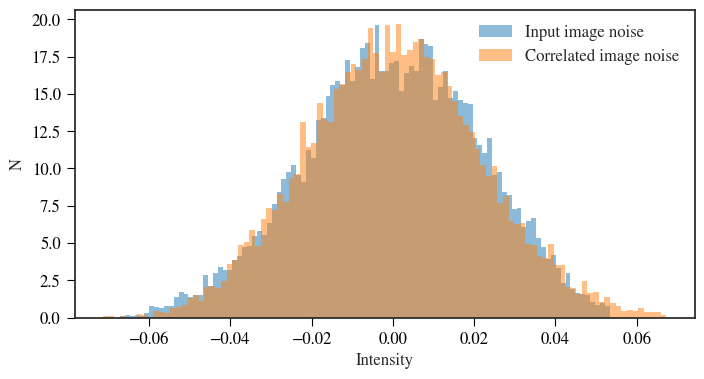

In [10]:

fig,axs = plt.subplots(1,figsize=(8,4))

axs.hist(img_nu.flatten()-img_bkg,bins = 100,density=True,alpha=0.5,
        label='Input image noise')
axs.hist(img_cor_masked.flatten(),bins = 100,density=True,alpha=0.5,
        label='Correlated image noise')

axs.set_ylabel('N')
axs.set_xlabel('Intensity')


plt.legend()
plt.show()